# Analisis de departamentos en venta en CABA

Determinaremos a partir del dataset obtenido en properati cual seria el precio segun cada barrio en CABA a partir de distintas variables.

Realizamos la limpieza en otra notebook para que despues quede el dataframe limpio para realizar los distintos modelos

## Librerias

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


# Importacion de los datos

En esta parte del proceso vamos a enriquecer los datos con datos desde Buenos Aires data, agregando los valores de superficies verdes por barrio

### Datos limpios desde Properati

In [41]:
# importamos el csv que ya tiene los datos limpios
data=pd.read_csv('dataframe_departamentos_caba.csv').iloc[ : , 1:]

In [42]:
data['creacion_registro']=pd.to_datetime(data['creacion_registro'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78769 entries, 0 to 78768
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   creacion_registro  78769 non-null  datetime64[ns]
 1   lat                78769 non-null  float64       
 2   lon                78769 non-null  float64       
 3   neighborhood       78769 non-null  object        
 4   rooms              78769 non-null  float64       
 5   bedrooms           78769 non-null  float64       
 6   bathrooms          78769 non-null  float64       
 7   surface_total      78769 non-null  float64       
 8   surface_covered    78769 non-null  float64       
 9   price              78769 non-null  float64       
 10  title              78769 non-null  object        
 11  description        78769 non-null  object        
dtypes: datetime64[ns](1), float64(8), object(3)
memory usage: 7.2+ MB


### Datos de espacios verdes por barrio y cantidad de puntos de recoleccion de basura y reciclado

In [43]:
espacios_verdes=pd.read_csv('Espacios verdes por barrio.csv').drop('Unnamed: 0',axis=1)

In [44]:
espacios_verdes.head()

,barrio,poblacion,wkt,comuna,perimetro,area,superficie_verde,sup_verde/hab,sup_verde/sup,centro_poligono,centro_poligono_str,longitud,latitud,superficie_verde_bins,porcentaje_de_superficie_verde
0,AGRONOMIA,13912,"POLYGON ((-58.4771156675186 -34.5951149914833,...",15,6556.17,2122169.34,2833.542,0.20,0.00,POINT (-58.48867265990651 -34.59294471940873),POINT (-58.48867265990651 -34.59294471940873),-58.488673,-34.592945,1,0.018626
1,ALMAGRO,131699,"POLYGON ((-58.4128700313089 -34.6141162515854,...",5,8537.90,4050752.25,9198.799,0.07,0.00,POINT (-58.4217445234198 -34.60922725926523),POINT (-58.4217445234198 -34.60922725926523),-58.421745,-34.609227,1,0.060469
2,BALVANERA,138926,"POLYGON ((-58.4119188098038 -34.5980030767748,...",3,8375.82,4342280.27,30755.787,0.22,0.01,POINT (-58.40306169003019 -34.60909939962956),POINT (-58.40306169003019 -34.60909939962956),-58.403062,-34.609099,2,0.202174
3,BARRACAS,89452,"POLYGON ((-58.3703353711449 -34.6329258371189,...",4,12789.79,7953453.43,225939.635,2.53,0.03,POINT (-58.38427181189788 -34.64640270803372),POINT (-58.38427181189788 -34.64640270803372),-58.384272,-34.646403,4,1.485219
4,BELGRANO,126267,"POLYGON ((-58.4505669109009 -34.5356104340406,...",13,20609.78,7999239.81,1278224.942,10.12,0.16,POINT (-58.4502414309702 -34.55476262833122),POINT (-58.4502414309702 -34.55476262833122),-58.450241,-34.554763,4,8.402439


In [45]:
# nos quedamos solamente con los datos de barrio y superficie verde y sup_verde/sup
espacios_verdes=espacios_verdes.loc[:,['barrio','area','superficie_verde','sup_verde/sup']]
espacios_verdes.head()

,barrio,area,superficie_verde,sup_verde/sup
0,AGRONOMIA,2122169.34,2833.542,0.00
1,ALMAGRO,4050752.25,9198.799,0.00
2,BALVANERA,4342280.27,30755.787,0.01
3,BARRACAS,7953453.43,225939.635,0.03
4,BELGRANO,7999239.81,1278224.942,0.16


### Unimos la tabla de espacio verde con el dataframe original

In [46]:
list(data['neighborhood'].unique())

['ALMAGRO',
 'PALERMO',
 'SAAVEDRA',
 'CHACARITA',
 'SAN NICOLÁS',
 'VILLA CRESPO',
 'VILLA PUEYRREDÓN',
 'COGHLAN',
 'BELGRANO',
 'VILLA DEVOTO',
 'VILLA URQUIZA',
 'BOEDO',
 'FLORES',
 'NUÑEZ',
 'BARRACAS',
 'RECOLETA',
 'COLEGIALES',
 'VILLA DEL PARQUE',
 'CABALLITO',
 'RETIRO',
 'FLORESTA',
 'BALVANERA',
 'MONTE CASTRO',
 'VILLA GENERAL MITRE',
 'PARQUE CHACABUCO',
 'PUERTO MADERO',
 'SAN CRISTOBAL',
 'VILLA SANTA RITA',
 'VILLA LUGANO',
 'MONSERRAT',
 'BOCA',
 'SAN TELMO',
 'LINIERS',
 'PARQUE PATRICIOS',
 'PATERNAL',
 'CONSTITUCIÓN',
 'VILLA LURO',
 'VERSALLES',
 'AGRONOMÍA',
 'VILLA REAL',
 'MATADEROS',
 'VILLA SOLDATI',
 'VILLA ORTUZAR',
 'PARQUE AVELLANEDA',
 'VELEZ SARSFIELD',
 'PARQUE CHAS',
 'VILLA RIACHUELO']

In [47]:
[i for i in espacios_verdes['barrio'].unique() if i not in data['neighborhood'].unique()]

['AGRONOMIA',
 'CONSTITUCION',
 'NUEVA POMPEYA',
 'SAN NICOLAS',
 'VILLA GRAL. MITRE',
 'VILLA PUEYRREDON']

In [48]:
# hacemos los reemplazos de las tildes y de los datos mal escritos
data['neighborhood']=data['neighborhood'].str.replace('Á','A')
data['neighborhood']=data['neighborhood'].str.replace('É','E')
data['neighborhood']=data['neighborhood'].str.replace('Í','I')
data['neighborhood']=data['neighborhood'].str.replace('Ó','O')
data['neighborhood']=data['neighborhood'].str.replace('Ú','U')
data['neighborhood']=data['neighborhood'].str.replace('VILLA GENERAL MITRE','VILLA GRAL. MITRE')


In [49]:
data_final=data.merge(espacios_verdes,
                      how='left',
                      left_on='neighborhood',
                      right_on='barrio').drop('barrio',axis=1)

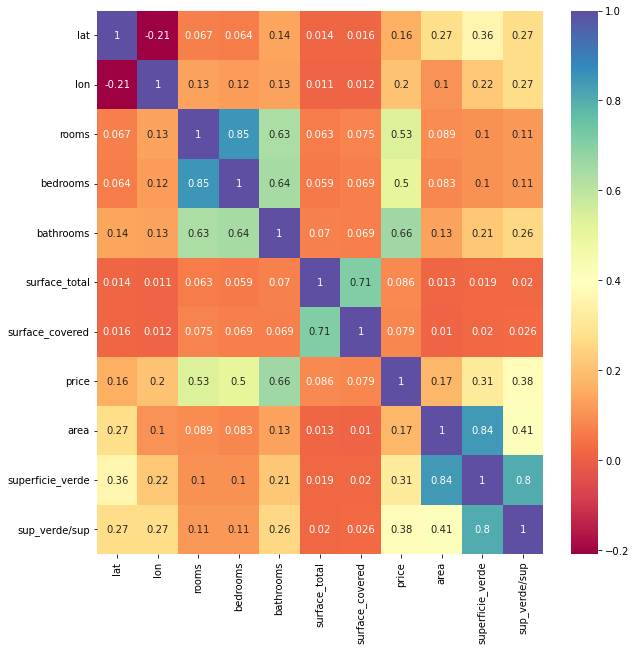

In [50]:
# vemos la relacion entre las distintas variables 
# observamos que solamente las variables bedrooms y rooms por un lado y las superficies tienen cierta relacion entre ellas

plt.figure(figsize=(10,10))

sns.heatmap(data_final.corr(),
            annot=True,
            cmap='Spectral'            
           )

plt.show()

In [51]:
data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,78769.0,-3.459404e+01,2.500775e-02,-3.469899e+01,-3.461253e+01,-3.459348e+01,-3.457652e+01,-3.453600e+01
lon,78769.0,-5.843624e+01,3.611998e-02,-5.852982e+01,-5.846106e+01,-5.843782e+01,-5.841121e+01,-5.834395e+01
rooms,78769.0,2.545646e+00,1.288997e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.500000e+01
bedrooms,78769.0,1.721236e+00,9.544316e-01,-1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.200000e+01
bathrooms,78769.0,1.426691e+00,7.627890e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+01
surface_total,78769.0,1.021204e+02,8.374816e+02,1.000000e+01,4.300000e+01,6.000000e+01,9.100000e+01,7.206000e+04
surface_covered,78769.0,8.108166e+01,5.693797e+02,1.000000e+00,3.900000e+01,5.400000e+01,8.000000e+01,6.735000e+04
price,78769.0,2.436127e+05,3.403640e+05,5.000000e+03,9.950000e+04,1.489000e+05,2.480000e+05,2.140000e+07
area,78769.0,7.125718e+06,4.567745e+06,1.232270e+06,4.050752e+06,6.317265e+06,7.999240e+06,1.584587e+07
superficie_verde,78769.0,7.224530e+05,8.918959e+05,3.552050e+02,4.282511e+04,2.158746e+05,1.278225e+06,2.860115e+06


### Analisis de outliers para la columna precio

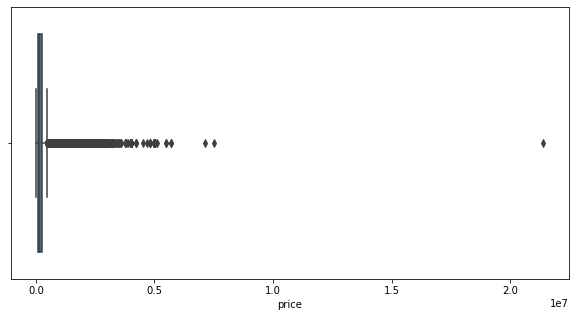

In [52]:
# hacemos un box plot para ver los outliers de precios
plt.figure(figsize=(10,5))

sns.boxplot(x=data_final['price'])

plt.show()

In [53]:
# elegimos el percentil 95 para eliminar los outliers
percentil_precio_95=np.percentile(data_final['price'],q=95)

In [54]:
# nos quedamos con los valores de precio menores al percentil 95
data_final=data_final.loc[data_final['price']<percentil_precio_95,:]

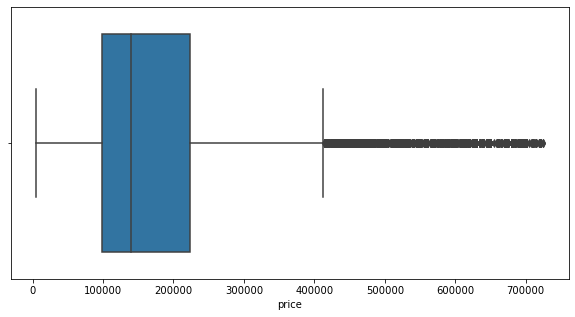

In [55]:
# hacemos un box plot para ver los outliers de precios
plt.figure(figsize=(10,5))

sns.boxplot(x=data_final['price'])

plt.show()

## Modelos

In [56]:
# Vamos a elegir las variables que seran las independientes y la dependiente el precio
X = data_final.loc[:,['lat','lon','bedrooms','bathrooms','surface_total','surface_covered','sup_verde/sup']]
Y = data_final['price']

In [57]:
# creamos el scaler para escalar los datos
scaler = StandardScaler()

In [58]:
# escalamos las columnas para obtener mejor resultado
scaler.fit(X)

StandardScaler()

In [59]:
X_esc=scaler.transform(X)

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X_esc, Y,train_size=.8)

### Random Forest

In [61]:
RFG=RandomForestRegressor(max_depth=4,
                          n_estimators=200,
                          )

In [62]:
RFG.fit(X_train,Y_train)

RandomForestRegressor(max_depth=4, n_estimators=200)

In [63]:
Y_pred=RFG.predict(X_test)

In [64]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

Mean Absolute Error: 40217.17181793291
Mean Squared Error: 3661340321.041189
Root Mean Squared Error: 60509.010246749116


In [26]:
# vemos la importancia de los distintas caracteristicas
importancia_variables=pd.DataFrame(RFG.feature_importances_,
             index=['lat','lon','bedrooms','bathrooms','surface_total','surface_covered','sup_verde/sup'],
            columns=['Feature importance']).sort_values(['Feature importance'],ascending=False)
importancia_variables

,Feature importance
surface_covered,0.740055
surface_total,0.143137
sup_verde/sup,0.085745
lat,0.012473
bathrooms,0.011717
lon,0.006873
bedrooms,0.000000


### Supported Vector Machines

In [126]:
# elegimos el kernel de la maquina de soporte vectorial
SVR = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)


In [127]:
# entrenamos el modelo - OJO CON EL TIEMPO DE EJECUCION
SVR.fit(X_train,Y_train)

SVR(C=100, coef0=1, gamma='auto', kernel='poly')

In [128]:
# vemos las predicciones
Y_pred=SVR.predict(X_test)

In [129]:
# vemos las metricas
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

Mean Absolute Error: 47967.181818081524
Mean Squared Error: 10255224930.094873
Root Mean Squared Error: 101268.08445949234


### Vecinos cercanos 

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(X_esc, Y,train_size=.8)

In [73]:
KNNR =KNeighborsRegressor(n_neighbors=1,algorithm='auto')

In [74]:
KNNR.fit(X_train,Y_train)

KNeighborsRegressor(n_neighbors=1)

In [75]:
Y_pred=KNNR.predict(X_test)

In [76]:
# vemos las metricas
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

Mean Absolute Error: 26364.80415608713
Mean Squared Error: 2608251929.940198
Root Mean Squared Error: 51071.04786412942


In [77]:
def KNNR(long):
    corrida= []
    MAE= []
    RMSE=[]

    for i in range(0,long):
        X_train, X_test, Y_train, Y_test = train_test_split(X_esc, Y,train_size=.8)
        KNNR =KNeighborsRegressor(n_neighbors=1,algorithm='auto')
        KNNR.fit(X_train,Y_train)
        Y_pred=KNNR.predict(X_test)
        corrida.append(i)
        MAE.append(metrics.mean_absolute_error(Y_test, Y_pred))
        RMSE.append(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
    
    return corrida, MAE, RMSE

In [78]:
resultados_KNNR=KNNR(1000)

In [90]:
resultados_KNNR=pd.DataFrame(resultados_KNNR).T
resultados_KNNR.columns=['corrida', 'MAE', 'RMSE']

In [91]:
resultados_KNNR.to_csv('resultados_KNNR.csv')

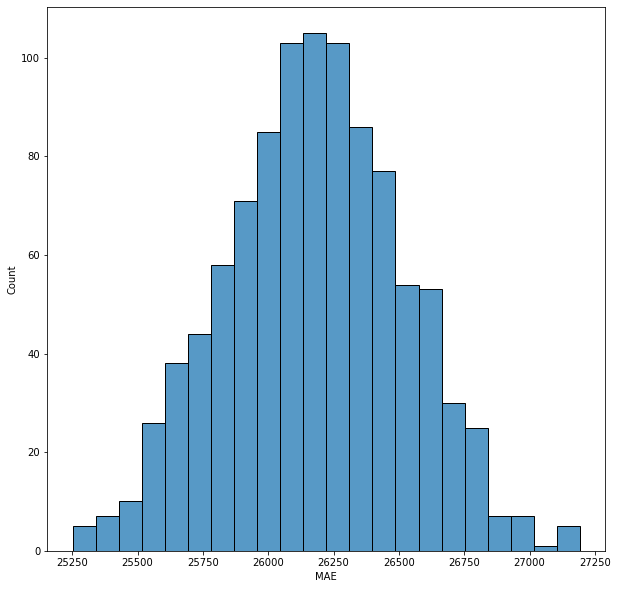

In [92]:
plt.figure(figsize=(10,10))

sns.histplot(resultados_KNNR['MAE'])

plt.savefig('histograma - MAE')
plt.show()

In [93]:
np.mean(resultados_KNNR['MAE']) 

26176.754703060305

In [94]:
np.median(resultados_KNNR['MAE'])

26178.72571161299

In [95]:
np.mean(data_final['price'])

183362.03954454942

In [96]:
np.median(data_final['price'])

140000.0

In [99]:
round(np.mean(resultados_KNNR['MAE'])/np.mean(data_final['price'])*100,2)

14.28

In [100]:
round(np.median(resultados_KNNR['MAE'])/np.median(data_final['price'])*100,2)

18.7